# Greenwood and Hanson (2013)

> Credit market sentiment measure from Greenwood and Hanson (2016)

In [ ]:
#| default_exp papers.greenwood_hanson_2013

In [ ]:
#|exports
from __future__ import annotations
from typing import List
from pathlib import Path
import os

from scipy.stats import norm
import pandas as pd
import numpy as np

import pandasmore as pdm
from finsets.wrds import wrds_api

In [ ]:
#| exports
DATA_REPO = Path(os.getenv('DATA_REPO')) #path to folder with all needed datasets (don't need it if you will be downloading them)

COMPA_PATH = DATA_REPO/'finsets/wrds/compa_ccm/processed.pkl.zip' #Compustat annual: 'dtdate','dltt','dlc'
COMPFT_PATH = DATA_REPO/'finsets/wrds/compa_ccm/features.pkl.zip' #Compustat annual: 'debtiss_tot_2la'
CRSPM_PATH = DATA_REPO/'finsets/wrds/crspm/processed.pkl.zip'  #Crsp monthly: 'prc','shrout','exchcd', 'siccd'
CRSPFT_PATH = DATA_REPO/'finsets/wrds/crspm/features.pkl.zip'  #CRSP monthly features: 'retvol12', 'lbhret12'


OUTPUT_PATH = DATA_REPO/'finsets/papers/greenwood_hanson/features.pkl.zip'

FREQ = 'A'
START_DATE = 1962
END_DATE = None
ENTITY_ID_IN_CLEAN_DSET = 'permno'
TIME_VAR_IN_CLEAN_DSET = f'{FREQ}date'

In [ ]:
#| export
def input_data():
    compa = pd.read_pickle(COMPA_PATH)[['dtdate','dltt','dlc']].copy()
    compft = pd.read_pickle(COMPFT_PATH)[['sic_full','debtiss_tot_2la']].copy()
    crspm = pd.read_pickle(CRSPM_PATH)[['ret','prc','shrout','exchcd','shrcd', 'siccd']].copy()
    crspft = pd.read_pickle(CRSPFT_PATH)[['retvol12', 'lbhret12']].copy()

    comp = pd.concat([compa,compft], axis=1).reset_index()
    comp['Mdate'] = comp.dtdate.dt.to_period('M')
    crsp = pd.concat([crspm,crspft], axis=1).reset_index()
    df = comp.merge(crsp, how='left', on=['permno','Mdate'])

    return df.set_index(['permno','Adate'])

In [ ]:
#| export
def calculate_default_prob(df: pd.DataFrame=None):

    if df is None: df = input_data()
    
    df = df.query('exchcd in [1,2,3] and shrcd in [10,11]').copy()

    df[['dltt','dlc']] = pdm.wins(df[['dltt','dlc']])
    df['F'] = df['dlc'] + df['dltt']/2
    df['E'] = abs(df['prc']) * df['shrout'] / 1000
    df['V'] = df['E'] + df['F']
    df.loc[(df.V<=0) | (df.F<=0) | (df.E==0) | (df.dlc<0) |(df.dltt<0), ['V','F']] = np.nan

    df['sigmaE'] = df['retvol12'] * (12**0.5)
    df['sigmaV'] = df.sigmaE * df.E / df.V + (0.05 + 0.25*df.sigmaE) * df.F / df.V 

    df['DD'] = (np.log(df.V / df.F) + df.lbhret12 - 0.5*(df.sigmaV**2)) / df.sigmaV
    df['DD'] = pdm.wins(df['DD'])
    df['EDF'] = norm.cdf(-df.DD) #expected default probability

    return df

In [ ]:
#| eval: false
df = calculate_default_prob()
df

dtdate       dltt       dlc sic_full  debtiss_tot_2la  \
permno Adate                                                             
10000  1986  1986-10-31      0.058     0.968     3942              NaN   
10001  1986  1986-06-30      2.946     0.343     4924              NaN   
       1987  1987-06-30      2.750     0.377     4924        -0.035615   
       1988  1988-06-30      2.555     0.325     4924        -0.022343   
       1989  1989-06-30      7.370     0.185     4924         0.483255   
...                 ...        ...       ...      ...              ...   
93436  2018  2018-12-31   9454.055  2629.460     3711         0.013900   
       2019  2019-12-31  11326.456  2070.000     3711         0.096660   
       2020  2020-12-31  10888.000  2459.000     3711         0.060655   
       2021  2021-12-31   6916.000  1957.000     3711         0.041152   
       2022  2022-12-31   3761.000  1987.000     3711         0.090679   

                Mdate       ret          prc     shrout exchcd  ... siccd  \
permno Adate                                                    ...         
10000  1986   1986-10 -0.242424    -0.781250     3843.0      3  ...  3990   
10001  1986   1986-06 -0.013069    -6.125000      985.0      3  ...  4920   
       1987   1987-06  0.051429     5.875000      991.0      3  ...  4920   
       1988   1988-06 -0.012039     6.250000      992.0      3  ...  4920   
       1989   1989-06  0.017143     7.000000     1001.0      3  ...  4920   
...               ...       ...          ...        ...    ...  ...   ...   
93436  2018   2018-12 -0.050445   332.799988   172602.0      3  ...  9999   
       2019   2019-12  0.267897   418.329987   181062.0      3  ...  9999   
       2020   2020-12  0.243252   705.669983   959854.0      3  ...  9999   
       2021   2021-12 -0.076855  1056.780029  1033508.0      3  ...  9999   
       2022   2022-12 -0.367334   123.180000  3157752.0      3  ...  9999   

              retvol12  lbhret12          F             E             V  \
permno Adate                                                              
10000  1986        NaN       NaN     0.9970  3.002344e+00  3.999344e+00   
10001  1986        NaN       NaN     1.8160  6.033125e+00  7.849125e+00   
       1987   0.050066  0.023884     1.7520  5.822125e+00  7.574125e+00   
       1988   0.048893  0.140535     1.6025  6.200000e+00  7.802500e+00   
       1989   0.030694  0.199810     3.8700  7.007000e+00  1.087700e+01   
...                ...       ...        ...           ...           ...   
93436  2018   0.145411  0.068893  7356.4875  5.744194e+04  6.479843e+04   
       2019   0.167923  0.257001  7733.2280  7.574366e+04  8.347689e+04   
       2020   0.303262  7.434370  7903.0000  6.773402e+05  6.852432e+05   
       2021   0.149601  0.497556  5415.0000  1.092191e+06  1.097606e+06   
       2022   0.183925 -0.650315  3867.5000  3.889719e+05  3.928394e+05   

                sigmaE    sigmaV         DD           EDF  
permno Adate                                               
10000  1986        NaN       NaN        NaN           NaN  
10001  1986        NaN       NaN        NaN           NaN  
       1987   0.173433  0.154911   9.527182  8.080565e-22  
       1988   0.169369  0.153549  11.147066  3.700316e-29  
       1989   0.106326  0.095743  12.832551  5.387843e-38  
...                ...       ...        ...           ...  
93436  2018   0.503720  0.466506   4.578244  2.344479e-06  
       2019   0.581704  0.545919   4.555673  2.610906e-06  
       2020   1.050532  1.042021  10.896128  6.013348e-28  
       2021   0.518233  0.516562  10.987744  2.188649e-28  
       2022   0.637137  0.632924   5.956763  1.286413e-09  

[260540 rows x 21 columns]

In [ ]:
#| export
def calculate_cms(df:pd.DataFrame=None):

    if df is None: df = calculate_default_prob()

    df['in_nyse'] = df['exchcd']==1
    df['issuance_quintile'] = pdm.bins_using_masked_cutoffs(df, sortvar='debtiss_tot_2la', maskvar='in_nyse', 
                                                            quantiles=[.2,.4,.6,.8])
    df['edf_decile'] = pdm.bins_using_masked_cutoffs(df, sortvar='EDF', maskvar='in_nyse', 
                                                            quantiles=[x/10 for x in range(1,10)])
    means = df.reset_index().groupby(['Adate', 'issuance_quintile'])['edf_decile'].mean().reset_index().set_index('Adate')
    means = means.pivot(columns='issuance_quintile', values='edf_decile')
    cms = means[5] - means[1]
    return cms

In [ ]:
#| eval: false
cms = calculate_cms()

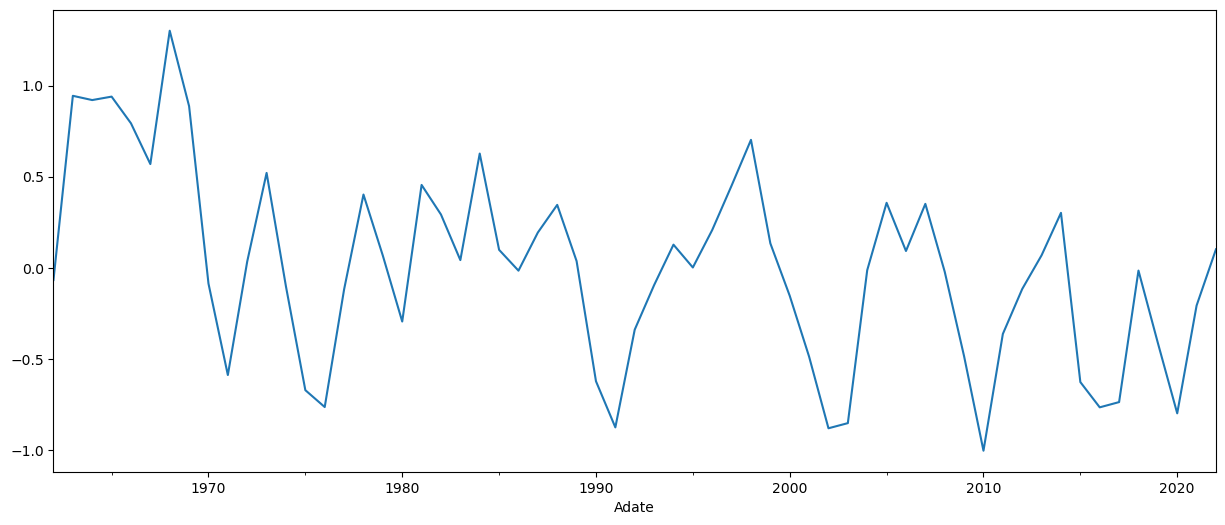

In [ ]:
#| eval: false
cms['1962':].plot(figsize=(15,6));

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()